# Regression using Pytorch

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from source.ffnn_model import WellLogFFNN
from source.ffnn_well_data_preprocessing import load_log_data

# Reproducibility, gotten from project 2
NP_RANDOM_SEED = 42
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)


In [2]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:",   X_val.shape)
print("X_test:",  X_test.shape)



[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Shapes:
X_train: torch.Size([8699, 11])
y_train: torch.Size([8699, 1])
X_val: torch.Size([1864, 11])
X_test: torch.Size([1865, 11])


In [3]:
# Basic statistics of y_train
print("y_train min:", y_train.min().item())
print("y_train max:", y_train.max().item())
print("y_train mean:", y_train.mean().item())
print("y_train std:", y_train.std().item())


y_train min: -5.169225692749023
y_train max: 3.0904221534729004
y_train mean: -1.3155641021000974e-09
y_train std: 1.0000574588775635


In [4]:
"""

Defining model and training function.

The model is a feedforward neural network defined in source/ffnn_model.py.

The training function uses MSE loss and Adam optimizer.

Code is adapted from project 2 part c.

"""

input_dim = X_train.shape[1]

# Defining model
def make_model(hidden_dims=(64, 64), dropout=0.2, activation=nn.ReLU):
    return WellLogFFNN(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=activation,
    )
# Training function
def train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr: float = 1e-3,
    epochs: int = 100,
    verbose: bool = False,
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_state_dict = None

    train_losses = []
    val_losses   = []

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # ---- VALIDATION ----
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:4d} | Train MSE: {loss.item():.4f} | Val MSE: {val_loss:.4f}")

    # last best weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model, best_val_loss, train_losses, val_losses


In [5]:
# Training with different configurations and evaluating on test set
configs = [
    {"name": "small_no_dropout",  "hidden_dims": (32, 32),        "lr": 1e-3, "dropout": 0.0},
    {"name": "medium_dropout",    "hidden_dims": (64, 64),        "lr": 1e-3, "dropout": 0.2},
    {"name": "deep_dropout",      "hidden_dims": (128, 64, 32),   "lr": 1e-4, "dropout": 0.2},
    {"name": "medium_lr_high",    "hidden_dims": (64, 64),        "lr": 1e-2, "dropout": 0.2},
]

results = []
histories = {}

for cfg in configs:
    print(f"\n=== Training config: {cfg['name']} ===")
    print(f"hidden_dims={cfg['hidden_dims']}, lr={cfg['lr']}, dropout={cfg['dropout']}")

    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)

    model = make_model(
        hidden_dims=cfg["hidden_dims"],
        dropout=cfg["dropout"],
        activation=nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=cfg["lr"],
        epochs=100,
        verbose=False,
    )

    # evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        test_mse = nn.MSELoss()(y_pred_test, y_test).item()

    results.append({
        "name":        cfg["name"],
        "hidden_dims": cfg["hidden_dims"],
        "lr":          cfg["lr"],
        "dropout":     cfg["dropout"],
        "val_mse":     best_val_mse,
        "test_mse":    test_mse,
    })

    histories[cfg["name"]] = {
        "train_losses": train_losses,
        "val_losses":   val_losses,
    }

results_df = pd.DataFrame(results)
display(results_df)



=== Training config: small_no_dropout ===
hidden_dims=(32, 32), lr=0.001, dropout=0.0

=== Training config: medium_dropout ===
hidden_dims=(64, 64), lr=0.001, dropout=0.2

=== Training config: deep_dropout ===
hidden_dims=(128, 64, 32), lr=0.0001, dropout=0.2

=== Training config: medium_lr_high ===
hidden_dims=(64, 64), lr=0.01, dropout=0.2


,name,hidden_dims,lr,dropout,val_mse,test_mse
0,small_no_dropout,"(32, 32)",0.0010,0.0,0.274606,0.258094
1,medium_dropout,"(64, 64)",0.0010,0.2,0.238565,0.223786
2,deep_dropout,"(128, 64, 32)",0.0001,0.2,0.713978,0.676403
3,medium_lr_high,"(64, 64)",0.0100,0.2,0.170331,0.165265


In [6]:
import optuna
from optuna.trial import Trial  

"""Objective function for Optuna hyperparameter optimization."""

# Define objective function for Optuna
def objective(trial):
    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(
        random_state=42
    )    
    
    
    # Suggest hyperparameters
    hidden_dim1 = trial.suggest_int("hidden_dim1", 16, 256, step=16)
    hidden_dim2 = trial.suggest_int("hidden_dim2", 16, 256, step=16)
    hidden_dim3 = trial.suggest_int("hidden_dim3", 16, 256, step=16)
    n_layers = trial.suggest_int("n_layers", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    
    # Build hidden_dims tuple based on n_layers
    hidden_dims_list = [hidden_dim1, hidden_dim2, hidden_dim3][:n_layers]
    hidden_dims = tuple(hidden_dims_list)
    
    # Reset seeds for reproducibility
    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)
    
    # Create and train model
    model = make_model(
        hidden_dims=hidden_dims,
        dropout=dropout, 
        activation=nn.ReLU,
    )
    model, best_val_mse, _, _ = train_model(
        model,
        X_train, y_train,
        X_val, y_val,
        lr=lr,
        epochs=100,
        verbose=False,
    )
    
    return best_val_mse

# Create and run Optuna study
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    study_name="ffnn_regression_rs42_new",
    storage="sqlite:///optuna_study.db",
    direction="minimize",
    load_if_exists=False,
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get best trial
best_trial = study.best_trial

print("\n" + "="*60)
print("OPTUNA OPTIMIZATION RESULTS")
print("="*60)
print(f"Best validation MSE: {best_trial.value:.6f}")
print("\nBest hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")
print("="*60)

/workspaces/project3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting Optuna hyperparameter optimization...


[I 2025-12-17 18:21:46,040] A new study created in RDB with name: ffnn_regression_rs42_new
  0%|          | 0/50 [00:00<?, ?it/s]

[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.21205:   2%|▏         | 1/50 [00:09<07:36,  9.32s/it]

[I 2025-12-17 18:21:55,355] Trial 0 finished with value: 0.21204979717731476 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 80, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0009497803331370219}. Best is trial 0 with value: 0.21204979717731476.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.21205:   4%|▍         | 2/50 [00:22<09:09, 11.46s/it]

[I 2025-12-17 18:22:08,311] Trial 1 finished with value: 0.3492263853549957 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 16, 'hidden_dim3': 240, 'n_layers': 4, 'dropout': 0.5, 'lr': 0.0009540770162320457}. Best is trial 0 with value: 0.21204979717731476.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.21205:   6%|▌         | 3/50 [00:32<08:38, 11.03s/it]

[I 2025-12-17 18:22:18,835] Trial 2 finished with value: 0.27259358763694763 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 192, 'hidden_dim3': 208, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.00022659815191163678}. Best is trial 0 with value: 0.21204979717731476.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.202852:   8%|▊         | 4/50 [00:45<08:59, 11.73s/it]

[I 2025-12-17 18:22:31,648] Trial 3 finished with value: 0.20285151898860931 and parameters: {'hidden_dim1': 48, 'hidden_dim2': 208, 'hidden_dim3': 256, 'n_layers': 4, 'dropout': 0.30000000000000004, 'lr': 0.008210381669242766}. Best is trial 3 with value: 0.20285151898860931.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.202852:  10%|█         | 5/50 [00:49<06:48,  9.07s/it]

[I 2025-12-17 18:22:35,996] Trial 4 finished with value: 0.8609789609909058 and parameters: {'hidden_dim1': 32, 'hidden_dim2': 160, 'hidden_dim3': 224, 'n_layers': 2, 'dropout': 0.4, 'lr': 3.603484663279176e-05}. Best is trial 3 with value: 0.20285151898860931.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.202852:  12%|█▏        | 6/50 [00:58<06:29,  8.85s/it]

[I 2025-12-17 18:22:44,404] Trial 5 finished with value: 0.2861848473548889 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 112, 'hidden_dim3': 96, 'n_layers': 4, 'dropout': 0.5, 'lr': 0.00040285169874743244}. Best is trial 3 with value: 0.20285151898860931.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.202852:  14%|█▍        | 7/50 [01:05<06:02,  8.43s/it]

[I 2025-12-17 18:22:51,982] Trial 6 finished with value: 0.21424618363380432 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 112, 'hidden_dim3': 16, 'n_layers': 3, 'dropout': 0.5, 'lr': 0.006117107183545718}. Best is trial 3 with value: 0.20285151898860931.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.202852:  16%|█▌        | 8/50 [01:18<06:45,  9.65s/it]

[I 2025-12-17 18:23:04,257] Trial 7 finished with value: 0.20371508598327637 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 256, 'hidden_dim3': 208, 'n_layers': 2, 'dropout': 0.30000000000000004, 'lr': 0.0011973520662606253}. Best is trial 3 with value: 0.20285151898860931.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.180739:  18%|█▊        | 9/50 [01:32<07:29, 10.97s/it]

[I 2025-12-17 18:23:18,114] Trial 8 finished with value: 0.18073885142803192 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 112, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.0080593160336472}. Best is trial 8 with value: 0.18073885142803192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.180739:  20%|██        | 10/50 [01:44<07:37, 11.43s/it]

[I 2025-12-17 18:23:30,588] Trial 9 finished with value: 0.22864282131195068 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 192, 'hidden_dim3': 96, 'n_layers': 3, 'dropout': 0.30000000000000004, 'lr': 0.0005266906486866841}. Best is trial 8 with value: 0.18073885142803192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.180739:  22%|██▏       | 11/50 [01:48<05:54,  9.09s/it]

[I 2025-12-17 18:23:34,367] Trial 10 finished with value: 0.8459441065788269 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 48, 'hidden_dim3': 160, 'n_layers': 3, 'dropout': 0.0, 'lr': 2.3219354882125743e-05}. Best is trial 8 with value: 0.18073885142803192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.180739:  24%|██▍       | 12/50 [02:04<07:10, 11.32s/it]

[I 2025-12-17 18:23:50,779] Trial 11 finished with value: 0.20079171657562256 and parameters: {'hidden_dim1': 96, 'hidden_dim2': 256, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.008784312061203914}. Best is trial 8 with value: 0.18073885142803192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.180739:  26%|██▌       | 13/50 [02:20<07:52, 12.77s/it]

[I 2025-12-17 18:24:06,906] Trial 12 finished with value: 0.21720896661281586 and parameters: {'hidden_dim1': 96, 'hidden_dim2': 256, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.003024282634958754}. Best is trial 8 with value: 0.18073885142803192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.180739:  28%|██▊       | 14/50 [02:31<07:16, 12.12s/it]

[I 2025-12-17 18:24:17,529] Trial 13 finished with value: 0.19551730155944824 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 144, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.0031693929838846045}. Best is trial 8 with value: 0.18073885142803192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.180739:  30%|███       | 15/50 [02:36<05:53, 10.10s/it]

[I 2025-12-17 18:24:22,929] Trial 14 finished with value: 0.19562974572181702 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 144, 'hidden_dim3': 160, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.002649153709987442}. Best is trial 8 with value: 0.18073885142803192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.180739:  32%|███▏      | 16/50 [02:46<05:38,  9.97s/it]

[I 2025-12-17 18:24:32,587] Trial 15 finished with value: 0.33448073267936707 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 96, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.00012777686868031474}. Best is trial 8 with value: 0.18073885142803192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.180739:  34%|███▍      | 17/50 [02:55<05:22,  9.78s/it]

[I 2025-12-17 18:24:41,933] Trial 16 finished with value: 0.1937277913093567 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 64, 'hidden_dim3': 112, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.0034908634099902972}. Best is trial 8 with value: 0.18073885142803192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.180739:  36%|███▌      | 18/50 [03:02<04:44,  8.90s/it]

[I 2025-12-17 18:24:48,786] Trial 17 finished with value: 0.19482682645320892 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 64, 'hidden_dim3': 96, 'n_layers': 2, 'dropout': 0.30000000000000004, 'lr': 0.0023731501647123736}. Best is trial 8 with value: 0.18073885142803192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.180739:  38%|███▊      | 19/50 [03:09<04:13,  8.18s/it]

[I 2025-12-17 18:24:55,283] Trial 18 finished with value: 0.5373114347457886 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 48, 'hidden_dim3': 48, 'n_layers': 2, 'dropout': 0.5, 'lr': 6.623545556271801e-05}. Best is trial 8 with value: 0.18073885142803192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.180739:  40%|████      | 20/50 [03:16<03:56,  7.88s/it]

[I 2025-12-17 18:25:02,471] Trial 19 finished with value: 0.9627779722213745 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 32, 'hidden_dim3': 128, 'n_layers': 3, 'dropout': 0.2, 'lr': 1.281566123582926e-05}. Best is trial 8 with value: 0.18073885142803192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 20. Best value: 0.151542:  42%|████▏     | 21/50 [03:23<03:40,  7.62s/it]

[I 2025-12-17 18:25:09,475] Trial 20 finished with value: 0.15154166519641876 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 80, 'hidden_dim3': 128, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.005097022104018673}. Best is trial 20 with value: 0.15154166519641876.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.141709:  44%|████▍     | 22/50 [03:27<03:01,  6.47s/it]

[I 2025-12-17 18:25:13,283] Trial 21 finished with value: 0.14170902967453003 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 80, 'hidden_dim3': 128, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.005161784775923186}. Best is trial 21 with value: 0.14170902967453003.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.141709:  46%|████▌     | 23/50 [03:30<02:28,  5.50s/it]

[I 2025-12-17 18:25:16,509] Trial 22 finished with value: 0.15179143846035004 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 96, 'hidden_dim3': 64, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.004912717760699291}. Best is trial 21 with value: 0.14170902967453003.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.141709:  48%|████▊     | 24/50 [03:33<02:04,  4.77s/it]

[I 2025-12-17 18:25:19,596] Trial 23 finished with value: 0.18794846534729004 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 80, 'hidden_dim3': 64, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0016064828338965575}. Best is trial 21 with value: 0.14170902967453003.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.141709:  50%|█████     | 25/50 [03:39<02:10,  5.23s/it]

[I 2025-12-17 18:25:25,870] Trial 24 finished with value: 0.14801031351089478 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 96, 'hidden_dim3': 64, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.004637919583520235}. Best is trial 21 with value: 0.14170902967453003.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.141709:  52%|█████▏    | 26/50 [03:47<02:24,  6.00s/it]

[I 2025-12-17 18:25:33,688] Trial 25 finished with value: 0.1797122061252594 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 128, 'hidden_dim3': 128, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0017440312497557621}. Best is trial 21 with value: 0.14170902967453003.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.141709:  54%|█████▍    | 27/50 [03:52<02:11,  5.71s/it]

[I 2025-12-17 18:25:38,711] Trial 26 finished with value: 0.16846947371959686 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 80, 'hidden_dim3': 16, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.004581584289258783}. Best is trial 21 with value: 0.14170902967453003.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.141709:  56%|█████▌    | 28/50 [03:57<01:57,  5.36s/it]

[I 2025-12-17 18:25:43,236] Trial 27 finished with value: 0.23677466809749603 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 48, 'hidden_dim3': 48, 'n_layers': 2, 'dropout': 0.1, 'lr': 0.0007478152682097676}. Best is trial 21 with value: 0.14170902967453003.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.141709:  58%|█████▊    | 29/50 [04:02<01:49,  5.21s/it]

[I 2025-12-17 18:25:48,104] Trial 28 finished with value: 0.24906592071056366 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 160, 'hidden_dim3': 144, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0002513472950243615}. Best is trial 21 with value: 0.14170902967453003.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.141709:  60%|██████    | 30/50 [04:07<01:44,  5.22s/it]

[I 2025-12-17 18:25:53,353] Trial 29 finished with value: 0.21225982904434204 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 16, 'hidden_dim3': 80, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0016886912575362668}. Best is trial 21 with value: 0.14170902967453003.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.141709:  62%|██████▏   | 31/50 [04:14<01:49,  5.75s/it]

[I 2025-12-17 18:26:00,330] Trial 30 finished with value: 0.1565108746290207 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 96, 'hidden_dim3': 144, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.005117618111907257}. Best is trial 21 with value: 0.14170902967453003.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.141709:  64%|██████▍   | 32/50 [04:17<01:28,  4.90s/it]

[I 2025-12-17 18:26:03,249] Trial 31 finished with value: 0.15525051951408386 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 96, 'hidden_dim3': 48, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.004845055564639639}. Best is trial 21 with value: 0.14170902967453003.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.141709:  66%|██████▌   | 33/50 [04:19<01:12,  4.25s/it]

[I 2025-12-17 18:26:05,990] Trial 32 finished with value: 0.14603422582149506 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 64, 'hidden_dim3': 64, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.008832954006112044}. Best is trial 21 with value: 0.14170902967453003.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  68%|██████▊   | 34/50 [04:23<01:04,  4.00s/it] 

[I 2025-12-17 18:26:09,400] Trial 33 finished with value: 0.13914047181606293 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 64, 'hidden_dim3': 112, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.008629584818360217}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  70%|███████   | 35/50 [04:26<00:56,  3.79s/it]

[I 2025-12-17 18:26:12,689] Trial 34 finished with value: 0.13984709978103638 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 64, 'hidden_dim3': 80, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.009184622474469306}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  72%|███████▏  | 36/50 [04:29<00:47,  3.41s/it]

[I 2025-12-17 18:26:15,224] Trial 35 finished with value: 0.15238326787948608 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 16, 'hidden_dim3': 112, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.009454142391554676}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  74%|███████▍  | 37/50 [04:32<00:44,  3.45s/it]

[I 2025-12-17 18:26:18,770] Trial 36 finished with value: 0.14032843708992004 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 64, 'hidden_dim3': 80, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.009789796723045118}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  76%|███████▌  | 38/50 [04:35<00:39,  3.30s/it]

[I 2025-12-17 18:26:21,732] Trial 37 finished with value: 0.14761699736118317 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 32, 'hidden_dim3': 112, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.009827108733212886}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  78%|███████▊  | 39/50 [04:42<00:48,  4.45s/it]

[I 2025-12-17 18:26:28,870] Trial 38 finished with value: 0.17200137674808502 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 32, 'hidden_dim3': 80, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.006109406311157454}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  80%|████████  | 40/50 [04:46<00:41,  4.14s/it]

[I 2025-12-17 18:26:32,270] Trial 39 finished with value: 0.14316853880882263 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 64, 'hidden_dim3': 80, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.006414244895884917}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  82%|████████▏ | 41/50 [04:50<00:36,  4.06s/it]

[I 2025-12-17 18:26:36,150] Trial 40 finished with value: 0.21289333701133728 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 128, 'hidden_dim3': 32, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0007775035216159204}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  84%|████████▍ | 42/50 [04:53<00:31,  3.88s/it]

[I 2025-12-17 18:26:39,620] Trial 41 finished with value: 0.14312095940113068 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 64, 'hidden_dim3': 80, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.006201230833237091}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  86%|████████▌ | 43/50 [04:54<00:21,  3.13s/it]

[I 2025-12-17 18:26:40,989] Trial 42 finished with value: 0.18102411925792694 and parameters: {'hidden_dim1': 16, 'hidden_dim2': 48, 'hidden_dim3': 96, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.006604412153896734}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  88%|████████▊ | 44/50 [04:58<00:19,  3.22s/it]

[I 2025-12-17 18:26:44,414] Trial 43 finished with value: 0.16139273345470428 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 64, 'hidden_dim3': 96, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0036809003553363476}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  90%|█████████ | 45/50 [05:06<00:23,  4.61s/it]

[I 2025-12-17 18:26:52,285] Trial 44 finished with value: 0.16813060641288757 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 80, 'hidden_dim3': 112, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0022180487680144557}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  92%|█████████▏| 46/50 [05:09<00:16,  4.08s/it]

[I 2025-12-17 18:26:55,128] Trial 45 finished with value: 0.15853449702262878 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 32, 'hidden_dim3': 80, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.006829026389817862}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 33. Best value: 0.13914:  94%|█████████▍| 47/50 [05:17<00:16,  5.47s/it]

[I 2025-12-17 18:27:03,831] Trial 46 finished with value: 0.1543847620487213 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 112, 'hidden_dim3': 144, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.003779251346459119}. Best is trial 33 with value: 0.13914047181606293.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 47. Best value: 0.131702:  96%|█████████▌| 48/50 [05:21<00:10,  5.05s/it]

[I 2025-12-17 18:27:07,898] Trial 47 finished with value: 0.13170242309570312 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 80, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.007320703417942379}. Best is trial 47 with value: 0.13170242309570312.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 47. Best value: 0.131702:  98%|█████████▊| 49/50 [05:26<00:05,  5.03s/it]

[I 2025-12-17 18:27:12,902] Trial 48 finished with value: 0.17286096513271332 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 112, 'hidden_dim3': 176, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0012568670985987828}. Best is trial 47 with value: 0.13170242309570312.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 47. Best value: 0.131702: 100%|██████████| 50/50 [05:32<00:00,  6.66s/it]

[I 2025-12-17 18:27:18,927] Trial 49 finished with value: 0.15765120089054108 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 80, 'hidden_dim3': 176, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.009486644360995727}. Best is trial 47 with value: 0.13170242309570312.

OPTUNA OPTIMIZATION RESULTS
Best validation MSE: 0.131702

Best hyperparameters:
  hidden_dim1: 208
  hidden_dim2: 80
  hidden_dim3: 160
  n_layers: 4
  dropout: 0.0
  lr: 0.007320703417942379


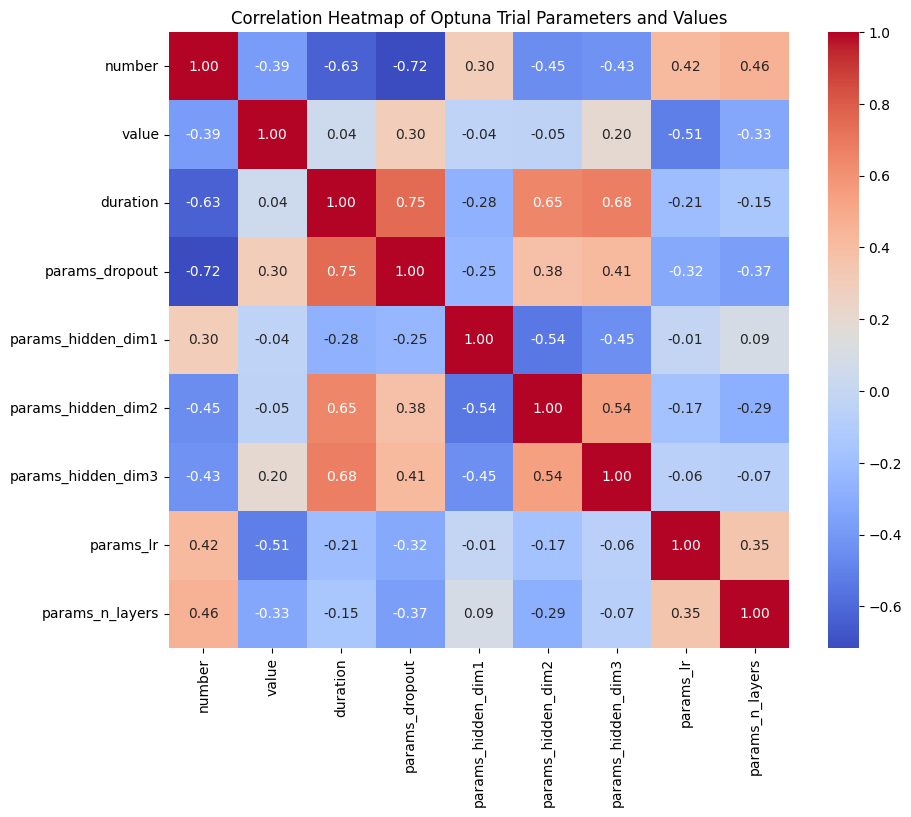

In [7]:
#plotting a heatmap of the optuna results
import seaborn as sns
import matplotlib.pyplot as plt

optuna_df = study.trials_dataframe()
plt.figure(figsize=(10, 8))
sns.heatmap(optuna_df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Optuna Trial Parameters and Values")
plt.show()

In [8]:
# === Extract best hyperparameters from Optuna ===
best_params = best_trial.params

# Build hidden layers tuple
n_layers = best_params["n_layers"]
best_hidden_dims = tuple([
    best_params["hidden_dim1"],
    best_params["hidden_dim2"],
    best_params["hidden_dim3"],
][:n_layers])

best_dropout = best_params["dropout"]
best_lr = best_params["lr"]

print("Using hidden_dims =", best_hidden_dims)
print("dropout =", best_dropout)
print("learning rate =", best_lr)


Using hidden_dims = (208, 80, 160)
dropout = 0.0
learning rate = 0.007320703417942379


Best config: medium_lr_high


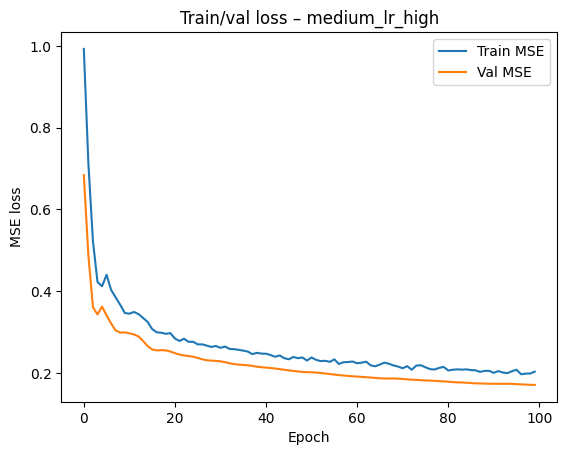

In [9]:
import matplotlib.pyplot as plt

y_pred_test_unscaled = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_test_unscaled      = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting train/val loss curves for best config
best_name = results_df.sort_values("val_mse").iloc[0]["name"]
print("Best config:", best_name)

train_losses = histories[best_name]["train_losses"]
val_losses   = histories[best_name]["val_losses"]

plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title(f"Train/val loss – {best_name}")
plt.show()


Best Optuna params: {'hidden_dim1': 208, 'hidden_dim2': 80, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.007320703417942379}
Using hidden_dims = (208, 80, 160) dropout = 0.0 lr = 0.007320703417942379


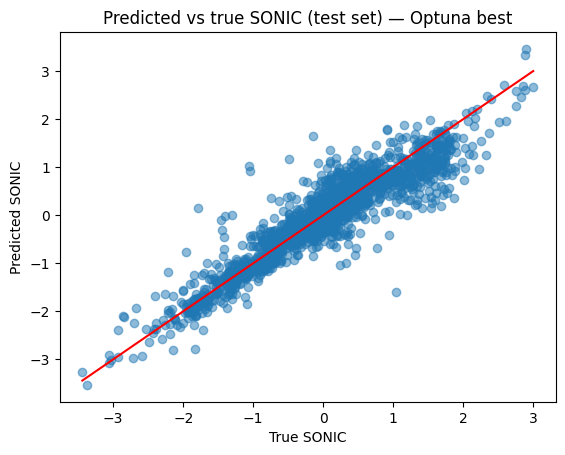

In [10]:
# Use Optuna best trial to rebuild & retrain the model, then plot preds vs true
params = best_trial.params
n_layers = params.get("n_layers", 2)
hidden_dims = tuple([params["hidden_dim1"], params["hidden_dim2"], params["hidden_dim3"]][:n_layers])
dropout = params.get("dropout", 0.0)
lr = params.get("lr", 1e-3)

print("Best Optuna params:", params)
print("Using hidden_dims =", hidden_dims, "dropout =", dropout, "lr =", lr)

# Reproducibility
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)

# Build and train model using Optuna params
model = make_model(
    hidden_dims=hidden_dims,
    dropout=dropout,
    activation=nn.ReLU,
)
model, _, _, _ = train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr=lr,
    epochs=100,
    verbose=False,
)

# Predictions on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).cpu().numpy()
y_true_test = y_test.cpu().numpy()

# Scatter plot
plt.figure()
plt.scatter(y_true_test, y_pred_test, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Optuna best")
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()], color="red")
plt.show()


[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 0: R² = 0.8452
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 1: R² = 0.8380
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 2: R² = 0.8545
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 3: R² = 0.8375
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 4: R² = 0.8524


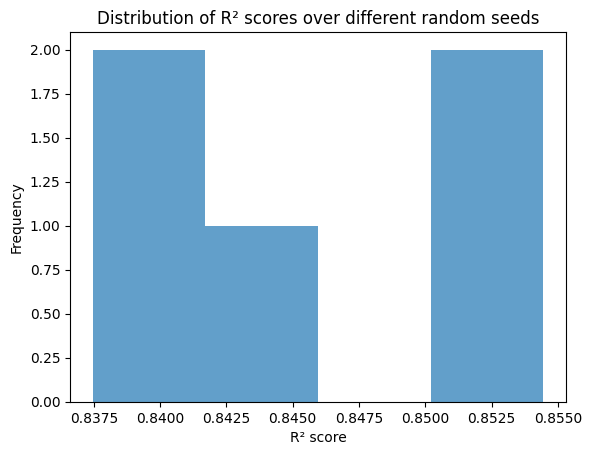

In [11]:
"""
Calculating R² score.
"""

from sklearn.metrics import r2_score

seeds = [0, 1, 2, 3, 4]
scores = []

for seed in seeds:
    # 1. new random split
    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

    # 2. train model with same hyperparameters
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = make_model(  # use best params fra Optuna
        hidden_dims = hidden_dims,
        dropout = best_dropout,
        activation = nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=best_lr,
        epochs=100,
        verbose=False,
    )

    # 3. evaluate on test
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)

    r2 = r2_score(
        y_test.numpy().ravel(),
        y_pred_test.numpy().ravel()
    )
    print(f"Seed {seed}: R² = {r2:.4f}")
    scores.append(r2)

print("R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Std  R²:", np.std(scores))

plt.figure()
plt.hist(scores, bins='auto', alpha=0.7)
plt.xlabel("R² score")
plt.ylabel("Frequency")
plt.title("Distribution of R² scores over different random seeds")
plt.show()



Ridge baseline:
Test MSE: 0.3214574456214905
Test R²: 0.683241069316864


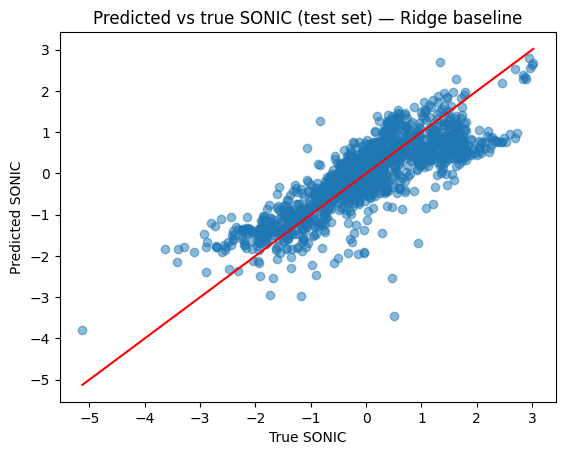

In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Convert tensors to numpy
X_tr = X_train.numpy()
y_tr = y_train.numpy().ravel()
X_te = X_test.numpy()
y_te = y_test.numpy().ravel()

ridge = Ridge(alpha=1.0)
ridge.fit(X_tr, y_tr)

ridge_pred = ridge.predict(X_te)

ridge_mse = mean_squared_error(y_te, ridge_pred)
ridge_r2  = r2_score(y_te, ridge_pred)

print("Ridge baseline:")
print("Test MSE:", ridge_mse)
print("Test R²:", ridge_r2)

plt.figure()
plt.scatter(y_te, ridge_pred, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Ridge baseline")
plt.plot([y_te.min(), y_te.max()],
            [y_te.min(), y_te.max()], color="red")
plt.show()
